In [55]:
import ast
from pathlib import Path
from collections import Counter

import spacy
import pandas as pd
import missingno as msno
from tqdm import tqdm

In [2]:
nlp = spacy.load('en_core_web_trf')

# Data Cleaning & Features

In [66]:
INTERIM_DATA_PATH = Path('data/interim')
SPOTIFY_BILLBOARD_DATA_PATH = INTERIM_DATA_PATH / 'spotify_billboard_data.csv'

PROCESSED_DATA_PATH = Path('data/processed')
PROCESSED_DATA_PATH.mkdir(exist_ok=True, parents=True)

ARTISTS_DATA_FILEPATH = PROCESSED_DATA_PATH / 'artists.csv'
LYRICS_DATA_FILEPATH  = PROCESSED_DATA_PATH / 'lyrics.csv'
TAGS_DATA_FILEPATH = PROCESSED_DATA_PATH / 'tags.csv'
SONGS_DATA_FILEPATH = PROCESSED_DATA_PATH / 'songs.csv'

## Loading Data

In [17]:
spotify_billboard_df = pd.read_csv(SPOTIFY_BILLBOARD_DATA_PATH, index_col=0)

print(spotify_billboard_df.shape)
spotify_billboard_df.head()

(4028, 40)


,index,name,artist,api_name,api_artists,danceability,energy,key,loudness,mode,...,num_words,num_lines,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,title,f_k_grade,difficult_words,num_dupes
0,5dae01pKNjRQtgOeAkFzPY,Mona Lisa,Nat King Cole,Mona Lisa,Nat King Cole,0.241,0.2370,1.0,-12.201,1.0,...,145,17,0.155,0.646,0.199,0.8443,Mona Lisa,2.9,13,10
1,1VBj7RIbwUOjNetvbECBTz,I Wanna Be Loved,Andrews Sisters,I Wanna Be Loved,"The Andrews Sisters,Gordon Jenkins & His Orche...",0.455,0.0792,8.0,-14.181,1.0,...,189,31,0.036,0.740,0.224,0.9897,I Wanna Be Loved,3.3,40,32
2,0BHroBUvBAp561BYqC9LRK,Tennessee Waltz,Patti Page,Tennessee Waltz,Patti Page,0.373,0.1240,5.0,-12.950,1.0,...,138,16,0.053,0.596,0.351,0.9948,Tennessee Waltz,2.9,5,10
3,0KnD456yC5JuweN932Ems3,I'll Never Be Free,Tennessee Ernie Ford,I'll Never Be Free,"Tennessee Ernie Ford,Kay Starr",0.697,0.1820,7.0,-12.586,1.0,...,117,18,0.167,0.602,0.231,0.8842,I'll Never Be Free,0.9,10,3
4,19vjeNqhgk0vhH5TuxDok9,All My Love,Patti Page,All My Love,Patti Page,0.627,0.1930,8.0,-14.935,1.0,...,32,3,0.070,0.850,0.079,0.0772,All My Love,6.0,9,0


In [18]:
spotify_billboard_df.columns

Index(['index', 'name', 'artist', 'api_name', 'api_artists', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'year',
       'lyrics', 'tags', 'num_syllables', 'pos', 'year.1', 'fog_index',
       'flesch_index', 'num_words', 'num_lines', 'sentiment_neg',
       'sentiment_neu', 'sentiment_pos', 'sentiment_compound', 'title',
       'f_k_grade', 'difficult_words', 'num_dupes'],
      dtype='object')

## Missing Values

<AxesSubplot:>

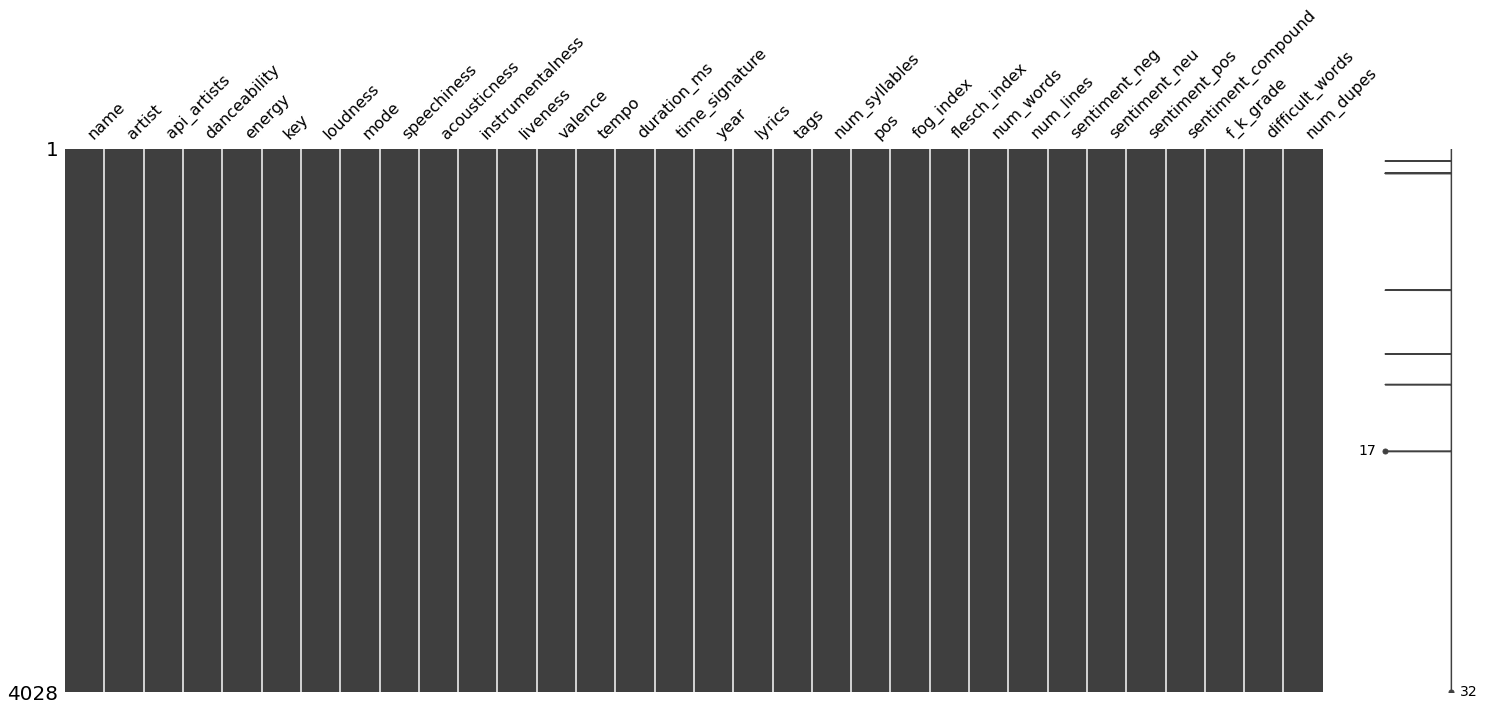

In [33]:
msno.matrix(data_df)

## Feature Selection

In [24]:
FEATURE_COLUMNS = [
    # Identification Features
    'name', 'artist', 'api_artists',
    
    # Spotify Features
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature',
    
    # Billboard Features
    'year', 'lyrics', 'tags', 'num_syllables', 'pos',
    'fog_index', 'flesch_index', 'num_words', 'num_lines',
    'sentiment_neg','sentiment_neu', 'sentiment_pos', 'sentiment_compound',
    'f_k_grade', 'difficult_words', 'num_dupes'
]

data_df = spotify_billboard_df[FEATURE_COLUMNS]

## Creating artists tables

In [29]:
artists_df = pd.DataFrame()
artists_col = data_df.api_artists.dropna()

for ix, value in tqdm(artists_col.iteritems(), total=len(artists_col)):
    if ix is not None and value is not None:
        artists = [(ix, artist) for artist in value.split(",")]
        artists_df = artists_df.append(artists)
        
artists_df = artists_df.rename(columns = {0: "index", 1: "artist"})
artists_df = artists_df.set_index("index")
artists_df.to_csv(ARTISTS_DATA_FILEPATH)

100%|██████████| 4021/4021 [00:05<00:00, 793.93it/s]


## Creating Lyrics Table

In [34]:
lyrics_list = []

for row in tqdm(data_df.itertuples(), total=len(data_df)):
    
    # Song & Lyrics Info
    song_name = row.name
    song_artist = row.artist
    song_api_index = row.Index
    doc = nlp(row.lyrics.lower())
    
    # Tokens and Counts
    word_freq_non_stop = Counter([
        token.lemma_ for token in doc 
        if token.is_stop != True 
        and token.is_punct != True 
        and '\n' not in token.text
    ])
    unique_words_non_stop = list(word_freq_non_stop.keys())
    freq_non_stop = list(word_freq_non_stop.values())

    word_freq_stop = Counter([
        token.lemma_ for token in doc 
        if token.is_stop == True 
        and token.is_punct != True 
        and '\n' not in token.text
    ])
    unique_words_stop = list(word_freq_stop.keys())
    freq_stop = list(word_freq_stop.values())
    
    # Creating DataFrame
    number_of_words = len(unique_words_stop) + len(unique_words_non_stop)
    
    lyrics_song_df = pd.DataFrame({
        "api_index": [song_api_index] * number_of_words,
        "song": [song_name]  * number_of_words,
        "artist": [song_artist] * number_of_words,
        "lemma": unique_words_stop + unique_words_non_stop,
        "count": freq_stop + freq_non_stop,
        "is_stop": ([True] * len(unique_words_stop)) + ([False] * len(unique_words_non_stop))
    })
    
    lyrics_list.append(lyrics_song_df)
    
lyrics_df = pd.concat(lyrics_list)
lyrics_df.to_csv(LYRICS_DATA_FILEPATH)

100%|██████████| 4028/4028 [1:03:27<00:00,  1.06it/s]


## Creating Tags Table

In [64]:
tags_df = pd.DataFrame()
tags_col = data_df.tags.dropna()

for ix, value in tqdm(tags_col.iteritems(), total=len(tags_col)):
    if ix is not None and value is not None:
        tags = [(ix, tag) for tag in ast.literal_eval(value)]
        tags_df = tags_df.append(tags)
        
tags_df = tags_df.rename(columns = {0: "index", 1: "tag"})
tags_df = tags_df.set_index("index")
tags_df.to_csv(TAGS_DATA_FILEPATH)

100%|██████████| 4028/4028 [00:06<00:00, 592.76it/s]


## Filtering Main Dataset

In [67]:
data_df = data_df.rename(columns = {'artist': 'main_artist'})
data_df = data_df.drop(columns=['api_artists', 'tags'])
data_df.to_csv(SONGS_DATA_FILEPATH)